In [1]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import lhsmdu

import matplotlib
import matplotlib.pyplot as plt

path = '/Users/zhanwentao/Documents/Abhi/Conference/IBC2024/data/'

R[write to console]: Loading required package: BRISC

R[write to console]: Loading required package: RANN

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: rdist

R[write to console]: Loading required package: matrixStats

R[write to console]: Loading required package: pbapply

R[write to console]: The ordering of inputs x (covariates) and y (response) in BRISC_estimation has been changed BRISC 1.0.0 onwards.
  Please check the new documentation with ?BRISC_estimation.



R package: BRISC installed


/Users/zhanwentao/opt/anaconda3/envs/NN/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def f5(X): return (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4]) / 6

sigma = 1
phi = 1
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 5;
funXY = f5

n = 1000
b = 10
nn = 20
batch_size = 50

In [3]:
torch.manual_seed(2024)
X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, b])

X, Y, coord, _ = geospaNN.spatial_order(X, Y, coord, method='max-min')
data = geospaNN.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn,
                                                      test_proportion=0.2)

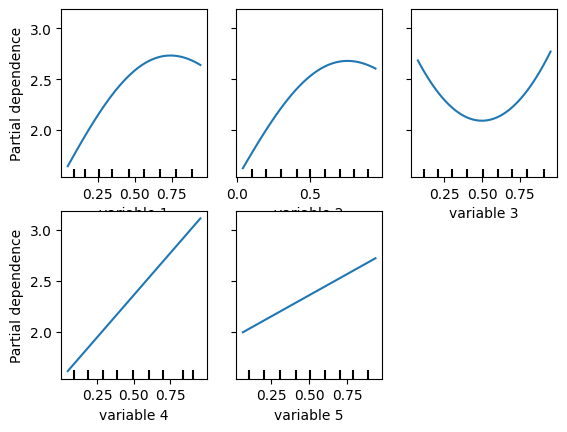

In [7]:
def f5(X): return (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 
                   10 * X[:, 3] + 5 * X[:, 4]) / 6
    
PDP_truth = geospaNN.visualize.plot_PDP(funXY, X, names = ["PDP"], save_path = path, save = True)

In [6]:
torch.manual_seed(2025)
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)
trainer_nn = geospaNN.nn_train(mlp_nn, lr=0.01, min_delta=0.001)
training_log = trainer_nn.train(data_train, data_val, data_test)
theta0 = geospaNN.theta_update(mlp_nn(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size=20)
print(theta0)

INFO: Early stopping
End at epoch48
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[0.72494506 1.21506875 0.19072005]
[0.72494506 1.21506875 0.19072005]


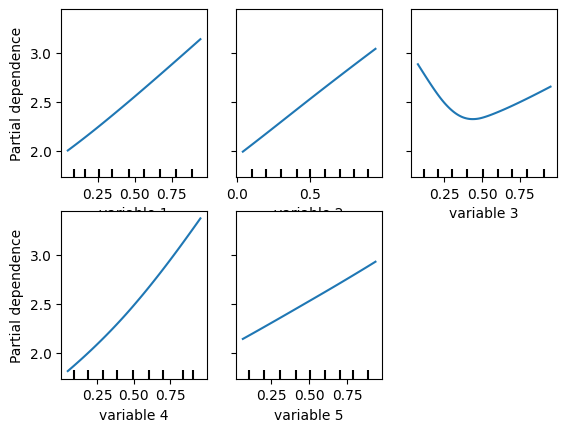

In [36]:
PDP_NN = geospaNN.visualize.plot_PDP(mlp_nn, X, names = ["PDP"], save_path = path, save = True)

In [37]:
torch.manual_seed(2025)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)
nngls = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
trainer_nngls = geospaNN.nngls_train(nngls, lr=0.01, min_delta=0.001)
training_log = trainer_nngls.train(data_train, data_val, data_test,
                                   Update_init=20, Update_step=10)

Theta updated from
[0.7588482  1.29918591 0.20202143]
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
to
[0.79616386 1.12321762 0.02482393]
Theta updated from
[0.79616386 1.12321762 0.02482393]
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 

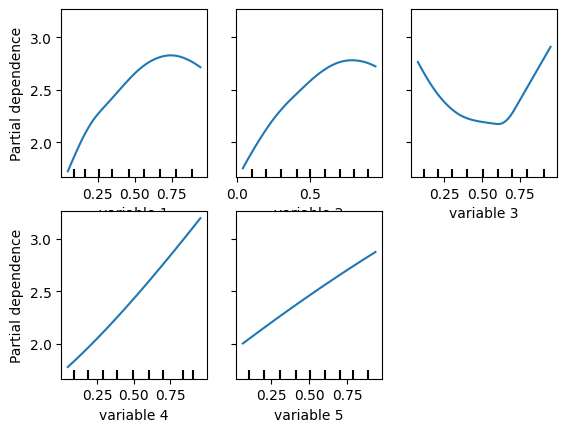

In [40]:
PDP_NNGLS = geospaNN.visualize.plot_PDP(mlp_nngls, X, names = ["PDP"], save_path = path, save = True)

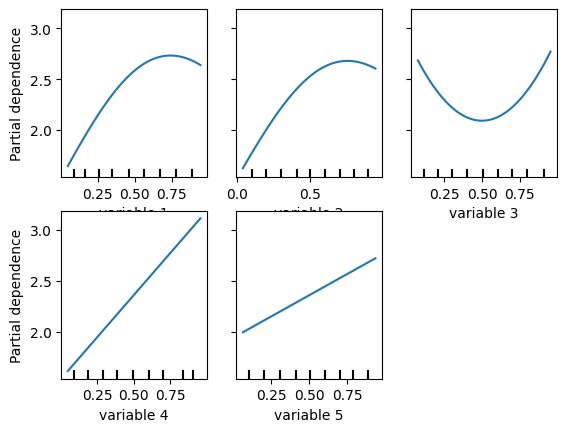

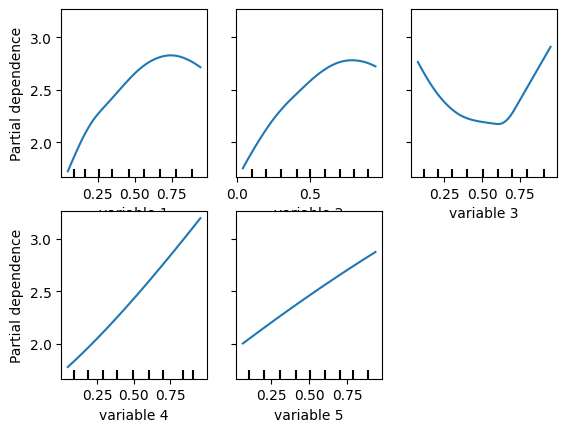

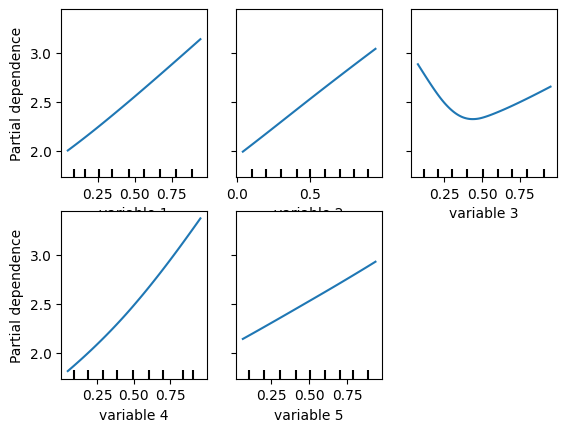

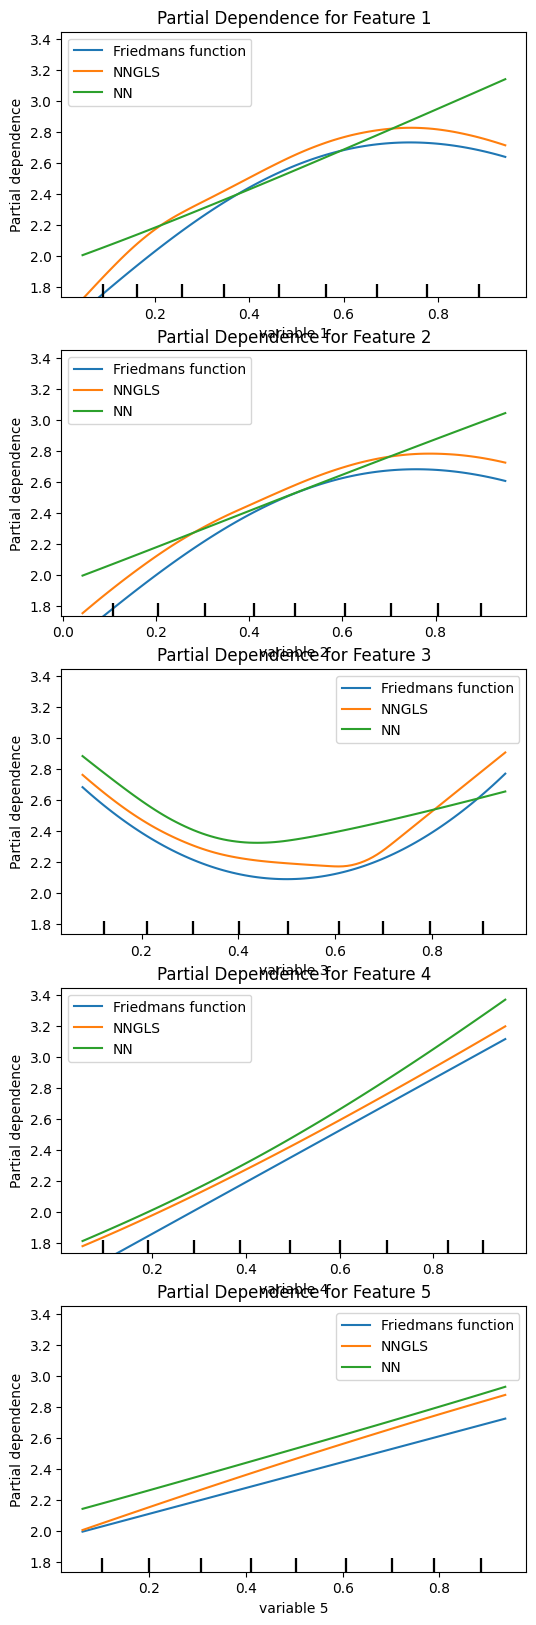

In [43]:
geospaNN.visualize.plot_PDP_list([funXY, mlp_nngls, mlp_nn], ['Friedmans function', 'NNGLS', 'NN'], X, split = True)